In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

plt.style.use(['science','no-latex'])
plt.rcParams.update({"figure.figsize":  (5,10),
                    'font.family': 'Times New Roman',
                    'font.size': 25,
                    'lines.linewidth': 2.5})

%load_ext autoreload
%autoreload 2
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataroot = "../data/era_interim/*.nc"

uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
uncropped['10UV_GDS4_SFC'] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
torch.cuda.empty_cache()
print(f"CUDA! {torch.cuda.memory_allocated()}")

CUDA! 0


In [2]:
midx = uncropped['10UV_GDS4_SFC'].values.shape[2] // 2
midy = uncropped['10UV_GDS4_SFC'].values.shape[1] //2
assert midx >= 2*midy

fine = uncropped['10UV_GDS4_SFC'][:, :, midx-midy:midx+midy]

sx, sy = 4, 4
coarse = np.array(fine.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean())
fine = np.array(fine)

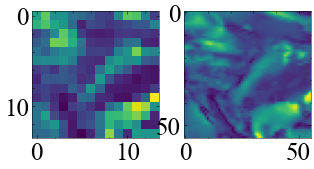

In [3]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse[0, ...])
ax[1].imshow(fine[0, ...])

In [4]:
fine_t = torch.from_numpy(fine)
coarse_t = torch.from_numpy(coarse)

In [5]:
class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine#.to(device)
        self.coarse = coarse#.to(device)

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]

        arr = torch.unsqueeze(arr, 0)
        carr = torch.unsqueeze(carr, 0)

#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr

dataset = NetCDFSR(
    fine_t,
    coarse_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

real_batch, real_cbatch = next(iter(dataloader))
fixed = {"coarse": real_cbatch, "fine": real_batch}
fixed["coarse"].size()

torch.Size([64, 1, 14, 14])

In [6]:
from models import Generator, Discriminator
G = Generator(14, 56, 1)

In [52]:
state = torch.load("checkpoints/losses/20210330-171352")

In [53]:
G.load_state_dict(state["generator"])

<All keys matched successfully>

In [54]:
coarse_t.size()


torch.Size([7308, 14, 14])

In [55]:
batch_size=64
i = np.random.randint(0, batch_size)
fake = G(fixed["coarse"]).detach().numpy()[i, 0, ...]
real = fixed["fine"].detach().numpy()[i, 0, ...]
coarse = fixed["coarse"].detach().numpy()[i, 0, ...]

In [56]:
# PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

fine_pca = fine.reshape(fine.shape[0], fine.shape[1]*fine.shape[2])
pca = PCA(n_components=250)
pca.fit(fine_pca)

ncomp = pca.components_.shape[0]
fine_sp_basis = pca.components_.reshape(ncomp, fine.shape[1]*fine.shape[2])
fine_sp_basis.shape

(250, 3136)

In [57]:
from scipy.interpolate import interp2d
x = np.arange(coarse.shape[0])
y = np.arange(coarse.shape[1])
nx = np.linspace(x.min(), x.max(), sx*x.shape[0])
ny = np.linspace(y.min(), y.max(), sy*y.shape[0])

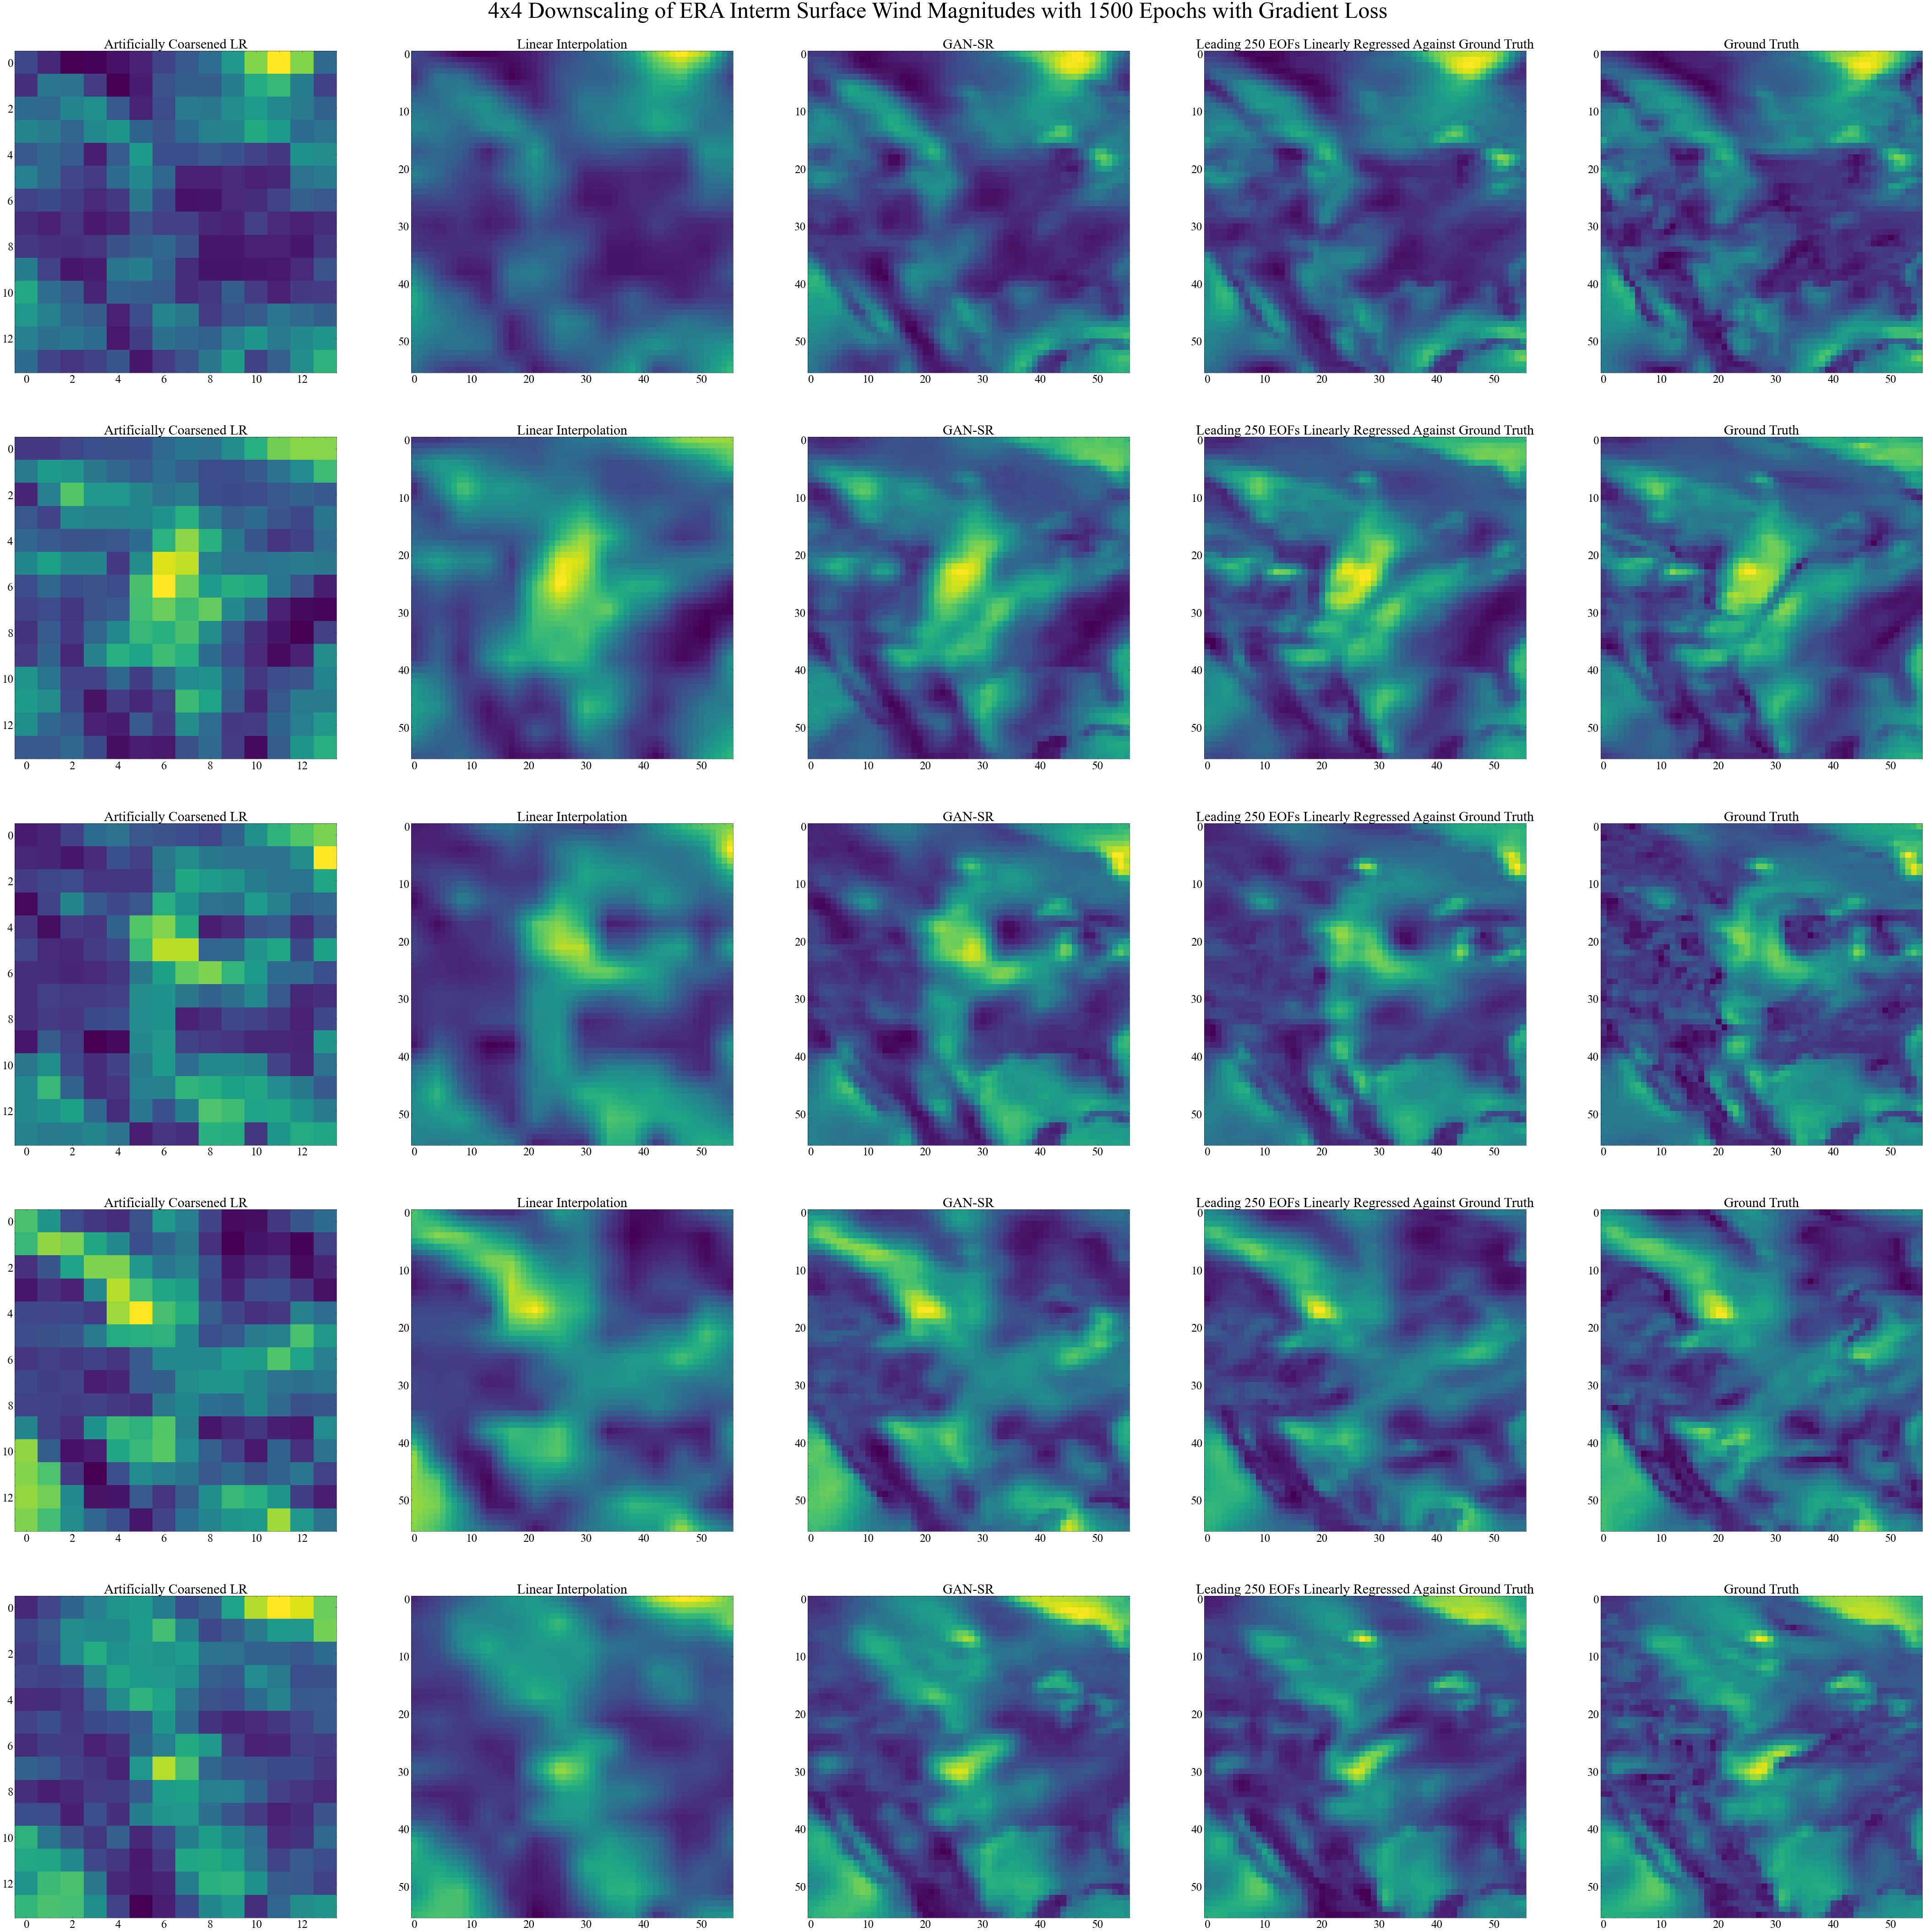

In [58]:
fig, ax = plt.subplots(5, 5, figsize=(75, 75))
np.random.seed(0)
for j in range(5):
    
    i = np.random.randint(0, batch_size, )

    fake = G(fixed["coarse"]).detach().numpy()[i, 0, ...]
    real = fixed["fine"].detach().numpy()[i, 0, ...]
    coarse = fixed["coarse"].detach().numpy()[i, 0, ...]
    
    flin = interp2d(x, y, coarse, kind='linear')
    naive_lin = flin(nx, ny)
    
    # Regressing leading EOFs
    reg = LinearRegression().fit(fine_sp_basis.T, real.flatten())
    leading_eofs = reg.predict(fine_sp_basis.T).reshape(real.shape)

    ax[j, 0].imshow(coarse)
    ax[j, 0].set_title("Artificially Coarsened LR")
    ax[j, 1].imshow(naive_lin)
    ax[j, 1].set_title("Linear Interpolation")
    ax[j, 2].imshow(fake)
    ax[j, 2].set_title("GAN-SR")
    ax[j, 3].imshow(leading_eofs)
    ax[j, 3].set_title(f"Leading {ncomp} EOFs Linearly Regressed Against Ground Truth")
    ax[j, 4].imshow(real)
    ax[j, 4].set_title("Ground Truth")

fig.suptitle('4x4 Downscaling of ERA Interm Surface Wind Magnitudes with 1500 Epochs with Gradient Loss', fontsize=50, y=0.9)
plt.savefig(f"sisr_gan_grid_gradient_loss_{ncomp}.png", facecolor='white')